NOTES:
The main issue here is that we don't know what test to do to compute the differece between a state's ranking vs how the other states rank. (Mann whitney U?)
The last graph looks "promising" but why all values are significant for all states makes no sense. (red vs blue)
Should we look simply whether there is a is statistical difference in average rating for the states? (not just whether it is higher than how other people score it)

Q1: Do Californians prefer Californian beer over non Californians? (Its for all US states but just for question focus purposes)
This question is for BeerAdvocate data which we established before has a lot of data on US states.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu

In [10]:
#rankings data with beer_location and user_location added as extra columns
BA_merged = pd.read_csv('../../minimizedData/BA_ratings_small_plus.csv')

In [11]:
BA_merged.head(2)

,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
0,Régab,142544.0,Societe des Brasseries du Gabon (SOBRAGA),37262.0,Euro Pale Lager,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"United States, Washington",2.88,Gabon
1,Barelegs Brew,19590.0,Strangford Lough Brewing Company Ltd,10093.0,English Pale Ale,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,"United States, New York",3.85,Northern Ireland


In [12]:
print(BA_merged.shape)
US_ratings = BA_merged.dropna(subset=['beer_location','user_location','rating'])
print(US_ratings.shape)
#we are only interested in focusing on the ratings that originate from US users AND are for US beers
US_ratings = US_ratings[US_ratings['user_location'].str.startswith('United States,')]
US_ratings = US_ratings[US_ratings['beer_location'].str.startswith('United States,')]

US_ratings.head(2)

(8393032, 15)
(7892754, 15)


,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,user_location,avg,beer_location
1008809,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.5,4.00,4.0,3.75,3.75,3.76,"United States, North Carolina",3.76,"United States, Wisconsin"
1008810,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.0,3.75,4.0,3.50,3.50,3.58,"United States, North Carolina",3.58,"United States, Wisconsin"


In [13]:
#removing the United States part from the location for both beer and user for clarity
US_ratings['user_state'] = US_ratings['user_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings['beer_state'] = US_ratings['beer_location'].apply(lambda x: x.split(',')[1].strip())
US_ratings = US_ratings.drop(['user_location','beer_location'], axis=1)

US_ratings = US_ratings[(US_ratings['user_state'] != 'United States') & (US_ratings['beer_state'] != 'United States')]


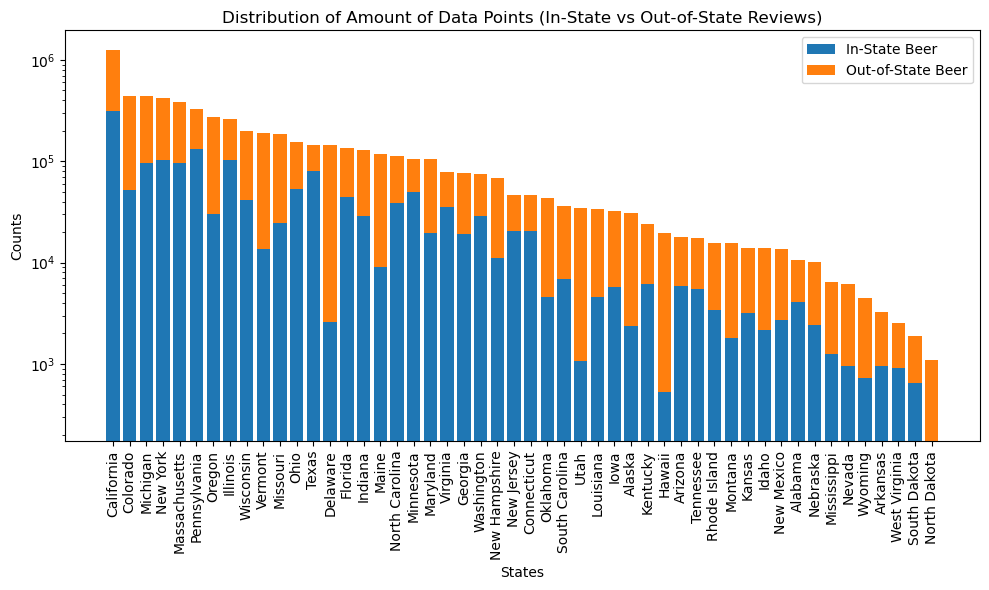

Hawaii in-state beer reviews: 533


In [14]:
US_ratings['beer_origin'] = np.where(
    US_ratings['beer_state'] == US_ratings['user_state'],
    'In-State Beer', 
    'Out-of-State Beer'
)

counts = US_ratings.groupby('beer_state')['avg'].count().sort_values(ascending=False)

in_out_counts = US_ratings.groupby(['beer_state', 'beer_origin'])['avg'].count().unstack(fill_value=0)

in_out_counts = in_out_counts.loc[counts.index]

plt.figure(figsize=(10, 6))

states = in_out_counts.index
ind = np.arange(len(states))
width = 0.8  # Bar width

plt.bar(ind, in_out_counts['In-State Beer'], width, label='In-State Beer')
plt.bar(ind, in_out_counts['Out-of-State Beer'], width,
        bottom=in_out_counts['In-State Beer'], label='Out-of-State Beer')

plt.title("Distribution of Amount of Data Points (In-State vs Out-of-State Reviews)")
plt.xlabel("States")
plt.xticks(ind, states, rotation=90)
plt.yscale('log')  # Use a logarithmic scale on the y-axis
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()

print('Hawaii in-state beer reviews:', in_out_counts.loc['Hawaii', 'In-State Beer'])


We have to remove:
- North Dakota

In [15]:
#Average rating of all users by state for all states
#Mean calculated by grouping rankings by user_state and beer_state

state_ratings = US_ratings.groupby(['user_state', 'beer_state'])['avg'].mean().reset_index()
state_ratings.head(2)

,user_state,beer_state,avg
0,Alabama,Alabama,3.842899
1,Alabama,Alaska,3.852717


In [16]:
#create matrix which gives the avg rating of each beers of state to user of state combination pair
#ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg')
state_ratings_matrix = state_ratings.pivot_table(index='user_state', columns='beer_state', values='avg', fill_value=0)
state_ratings_matrix.head(2)

beer_state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
user_state,,,,,,,,,,,,,,,,,,,,,
Alabama,3.842899,3.852717,3.240513,3.717222,3.991335,3.772443,4.045263,3.949393,3.831054,3.831031,...,3.746667,3.765035,3.655649,3.656977,3.801226,3.690347,3.681420,3.747143,3.390454,3.908
Alaska,3.809091,3.908503,3.763333,3.480000,4.029584,3.872363,4.036000,3.965247,3.948252,3.872750,...,3.587500,3.740000,3.842672,3.915357,4.098214,3.800000,3.825049,3.430000,3.534313,4.104


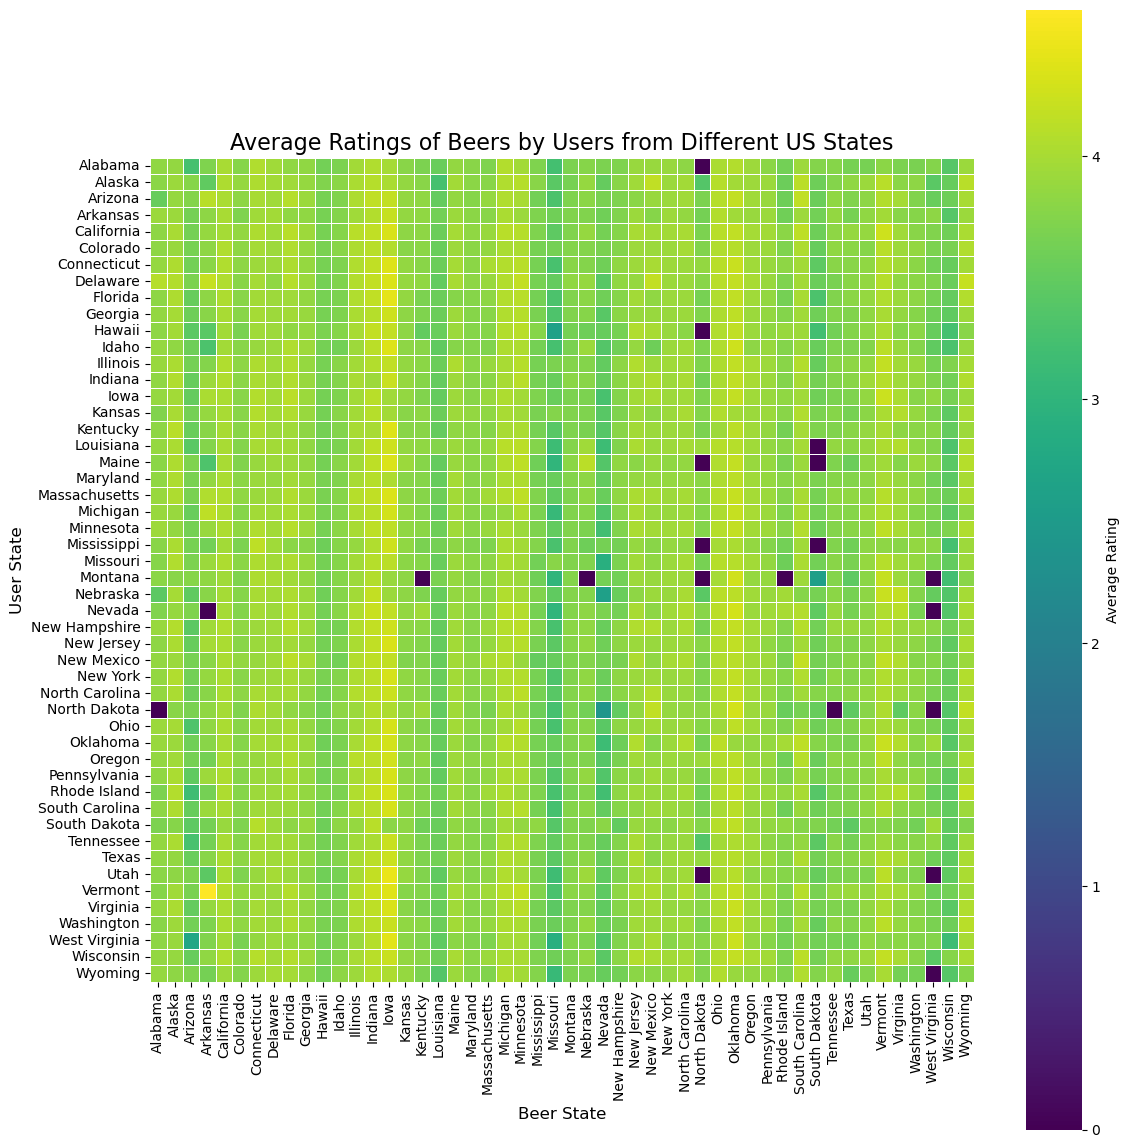

In [17]:
plt.figure(figsize=(12, 12))

sns.heatmap(state_ratings_matrix, annot=False, fmt=".2f", cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Average Rating'}, square=True)

plt.title('Average Ratings of Beers by Users from Different US States', fontsize=16)
plt.xlabel('Beer State', fontsize=12)
plt.ylabel('User State', fontsize=12)
plt.tight_layout()

plt.show()


There are several problems here: when there are no ratings we need to put Nan not 0.

Below we are comparing the difference between the average ratings for the beers in the state compared to the average rating given by all other 49 states.

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/1064256621.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(


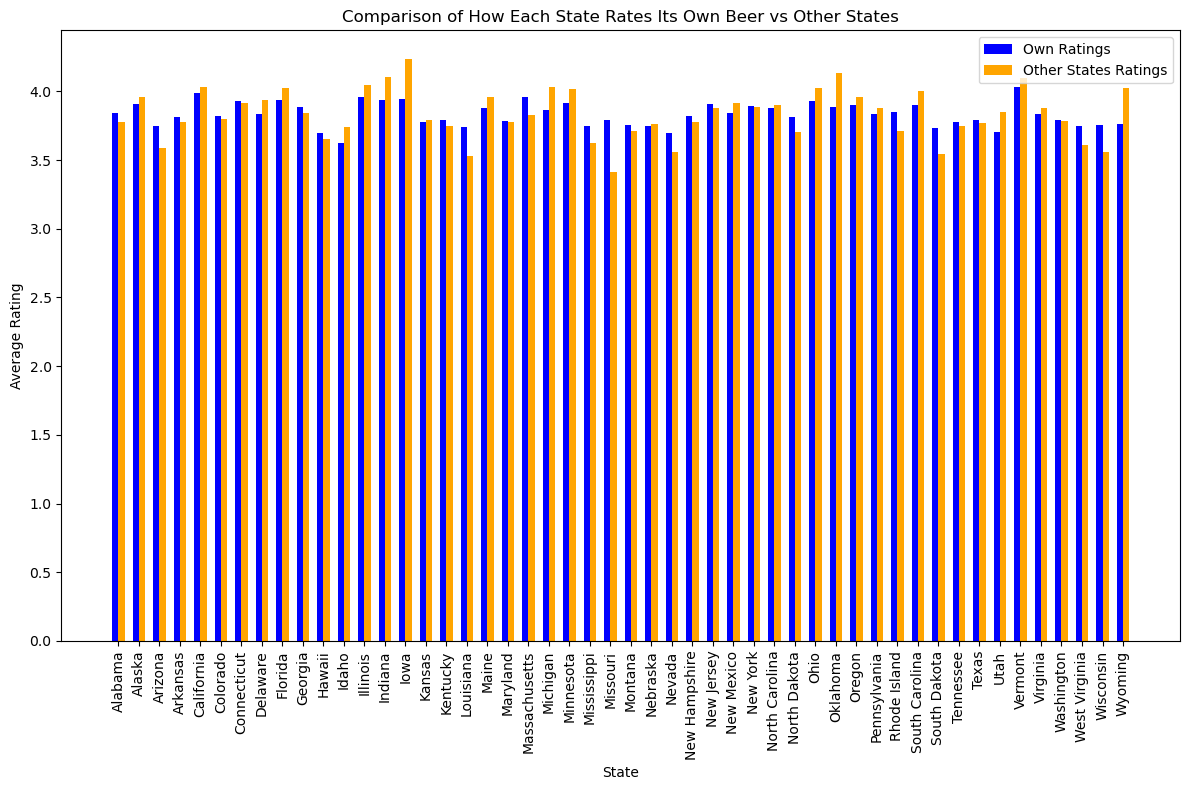

In [18]:
#average ratings for each state when rating its own beer
own_beer_ratings = US_ratings[US_ratings['user_state'] == US_ratings['beer_state']].groupby('beer_state')['avg'].mean()

#total number of ratings per beer_state
total_ratings_per_state = US_ratings.groupby('beer_state').size()

#weighted average rating for each beer by other states
other_state_ratings = US_ratings[US_ratings['user_state'] != US_ratings['beer_state']]
other_state_avg_ratings = other_state_ratings.groupby('beer_state').apply(
    lambda group: np.average(group['rating'], weights=group['user_state'].map(total_ratings_per_state))
)

ratings_comparison = pd.DataFrame({
    'own_beer_avg': own_beer_ratings,
    'other_states_avg': other_state_avg_ratings
})

ratings_comparison['other_states_avg'] = ratings_comparison['other_states_avg'].fillna(0)
plt.figure(figsize=(12, 8))

bar_width = 0.3
index = np.arange(len(ratings_comparison)) 

#allows us to place the bars next to each other
plt.bar(index - bar_width / 2, ratings_comparison['own_beer_avg'], bar_width, label='Own Ratings', color='blue')
plt.bar(index + bar_width / 2, ratings_comparison['other_states_avg'], bar_width, label='Other States Ratings', color='orange')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of How Each State Rates Its Own Beer vs Other States')
plt.xticks(index, ratings_comparison.index, rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/897117608.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]],


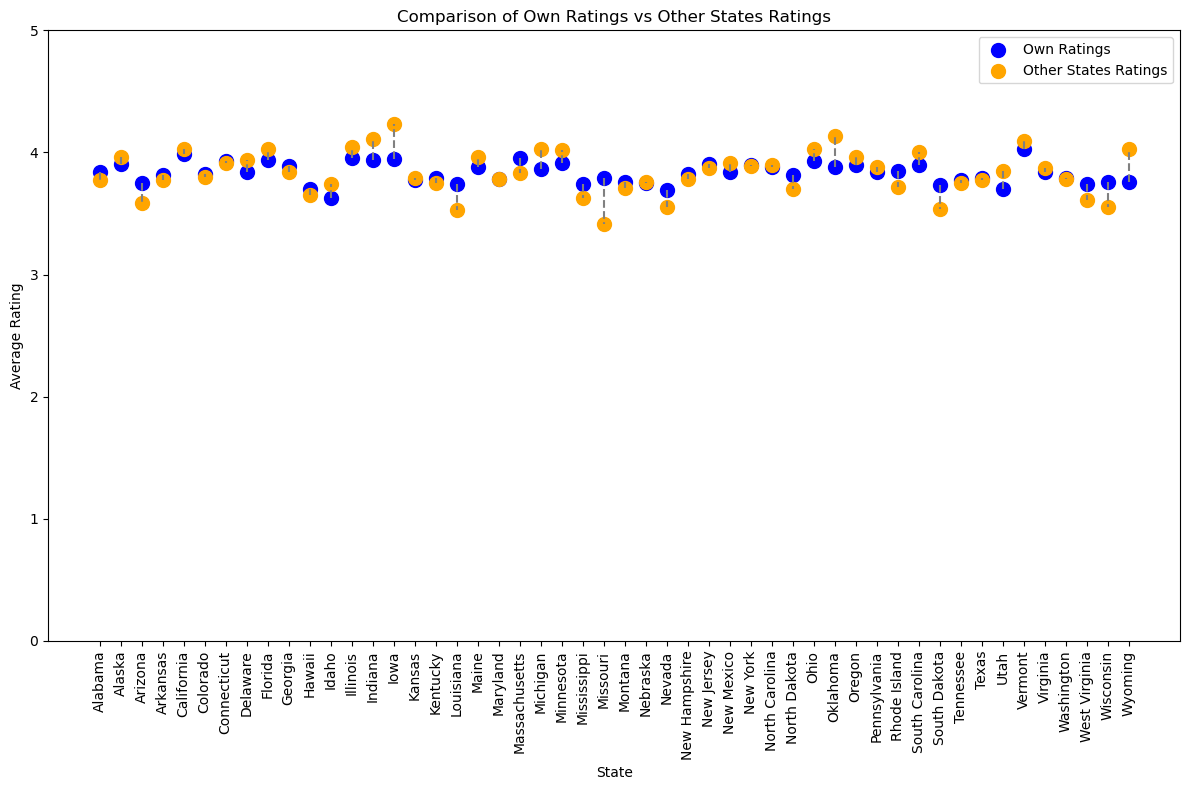

In [19]:
plt.figure(figsize=(12, 8))

#dots for better visibility
plt.scatter(ratings_comparison.index, ratings_comparison['own_beer_avg'], label='Own Ratings', color='blue', s=100, zorder=2)
plt.scatter(ratings_comparison.index, ratings_comparison['other_states_avg'], label='Other States Ratings', color='orange', s=100, zorder=2)

#lines connecting the dots for visibility
for i in range(len(ratings_comparison)):
    plt.plot([ratings_comparison.index[i], ratings_comparison.index[i]], 
             [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]], 
             color='gray', linestyle='--')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of Own Ratings vs Other States Ratings')
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()

plt.show()


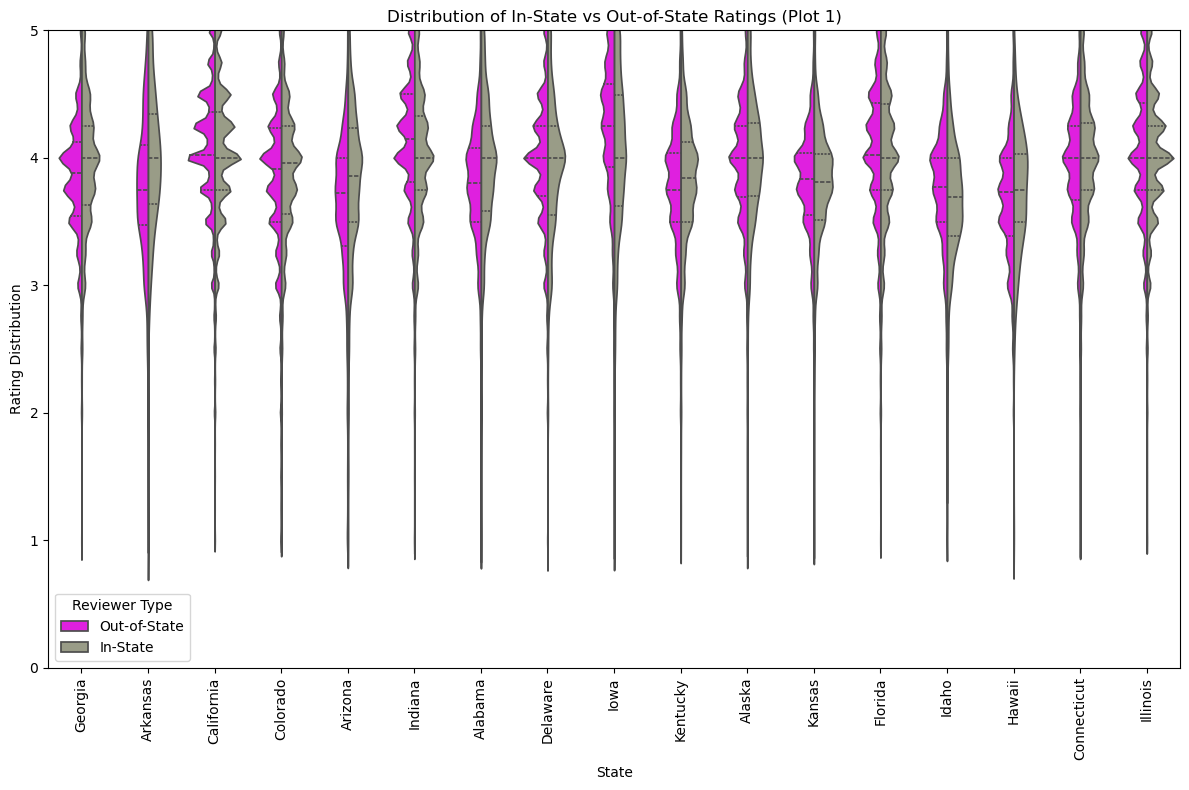

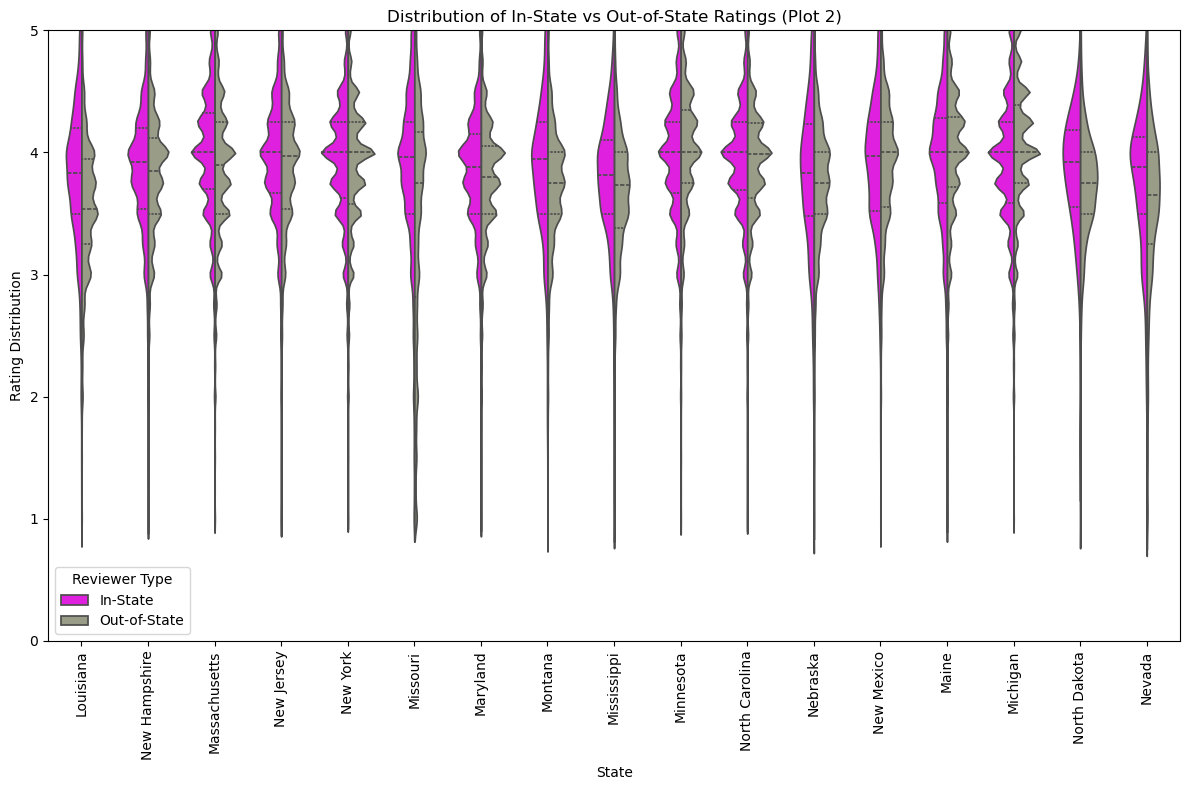

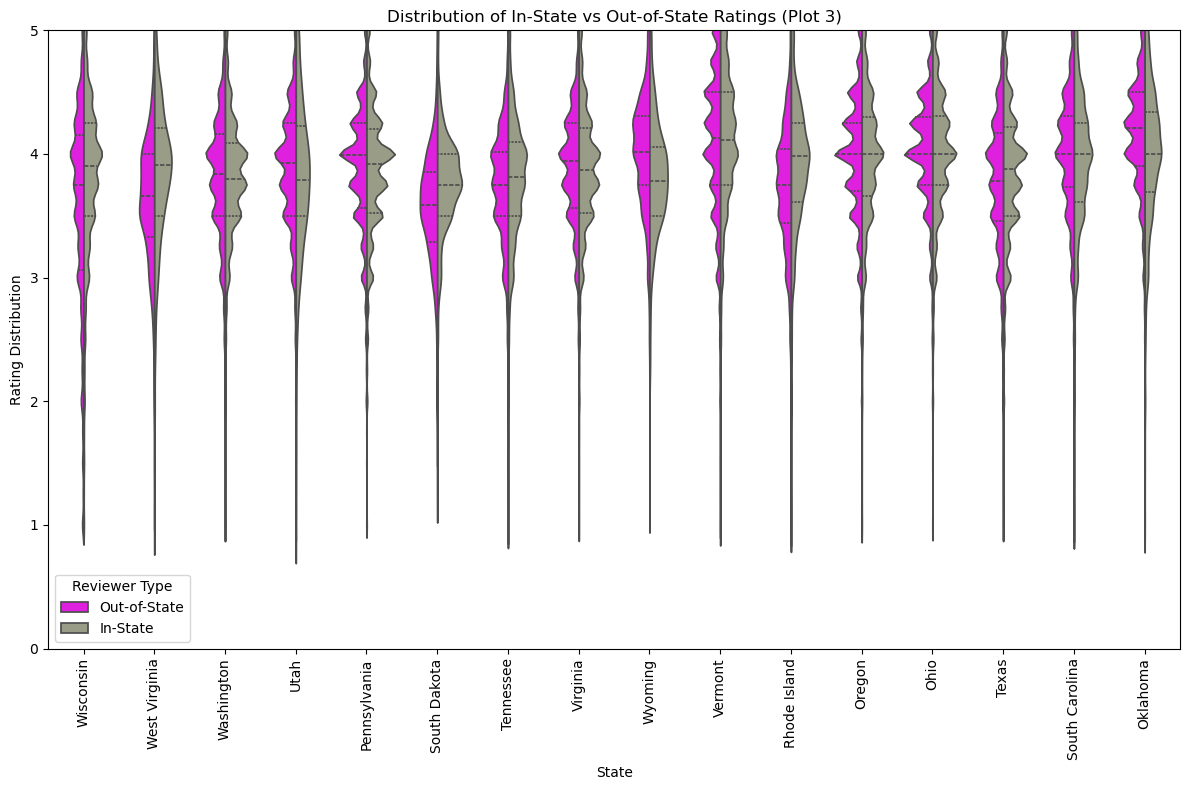

In [20]:
import math

US_ratings['state_IN_VS_OUT'] = np.where(
    US_ratings['user_state'] == US_ratings['beer_state'], 
    'In-State', 
    'Out-of-State'
)

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()  

num_figures = 3  
num_states = len(unique_states)
states_per_figure = math.ceil(num_states / num_figures)

custom_palette = ['magenta', '#9c9f84'] 

for i in range(num_figures):
    start_idx = i * states_per_figure
    end_idx = min((i + 1) * states_per_figure, num_states)
    subset_states = unique_states[start_idx:end_idx]
    
    subset_data = US_ratings[US_ratings['beer_state'].isin(subset_states)]
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        x='beer_state', 
        y='rating', 
        hue='state_IN_VS_OUT', 
        data=subset_data, 
        palette=custom_palette, 
        split=True, 
        inner='quartile'
    )

    plt.xlabel('State')
    plt.ylabel('Rating Distribution')
    plt.title(f'Distribution of In-State vs Out-of-State Ratings (Plot {i+1})')
    plt.xticks(rotation=90)
    plt.ylim(0, 5)
    plt.legend(title='Reviewer Type')
    plt.tight_layout()
    plt.show()



/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/4153175424.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


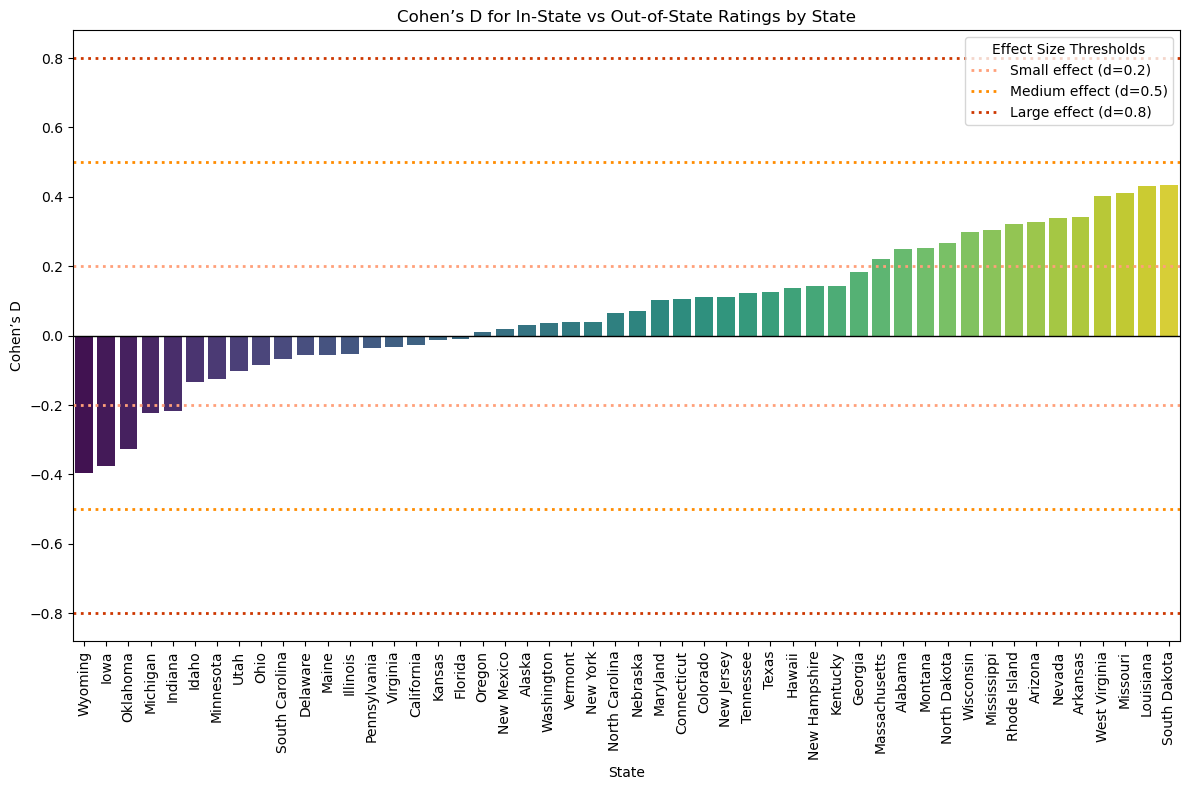

In [21]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Optional: sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()

plt.figure(figsize=(12, 8))

sns.barplot(
    x=cohen_df_no_nan.index, 
    y='Cohen_d', 
    data=cohen_df_no_nan, 
    palette='viridis'
)

plt.axhline(y=0, color='black', linewidth=1)

plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)

plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State')

plt.xticks(rotation=90)

plt.legend(title='Effect Size Thresholds', loc='upper right')

plt.tight_layout()
plt.show()

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/475010455.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


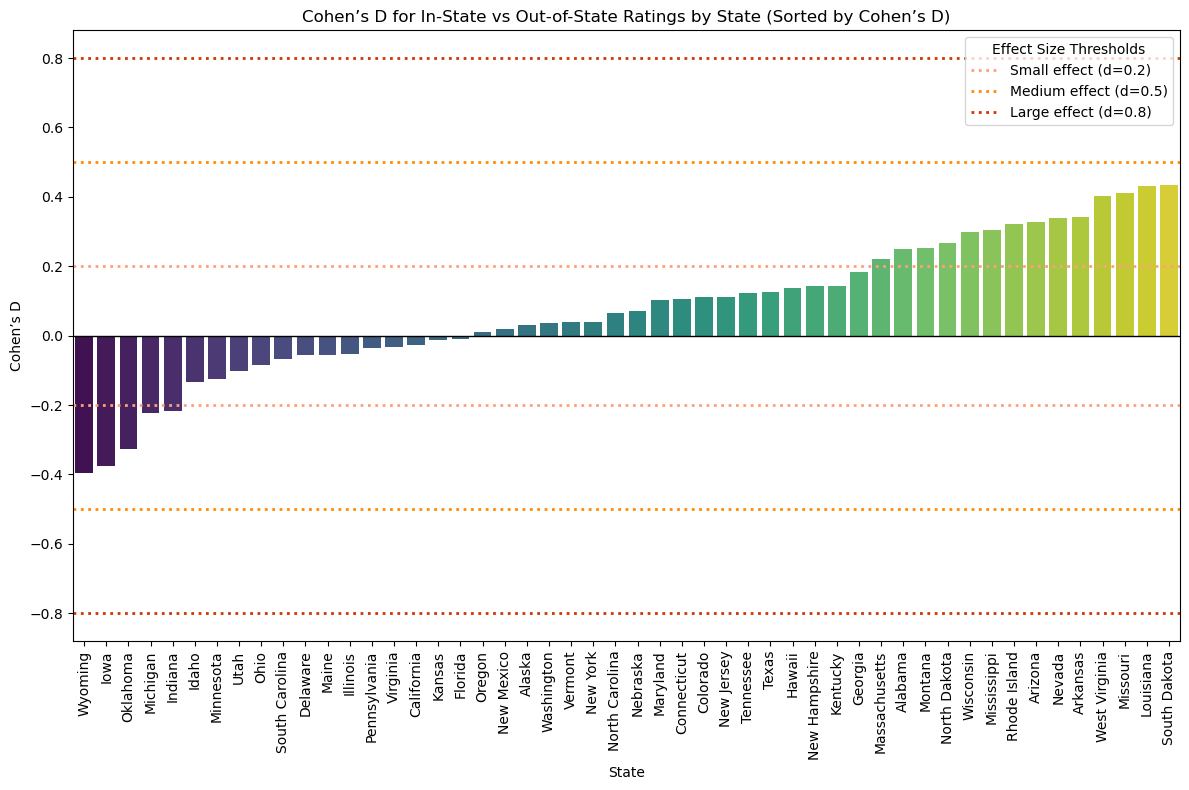

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/475010455.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


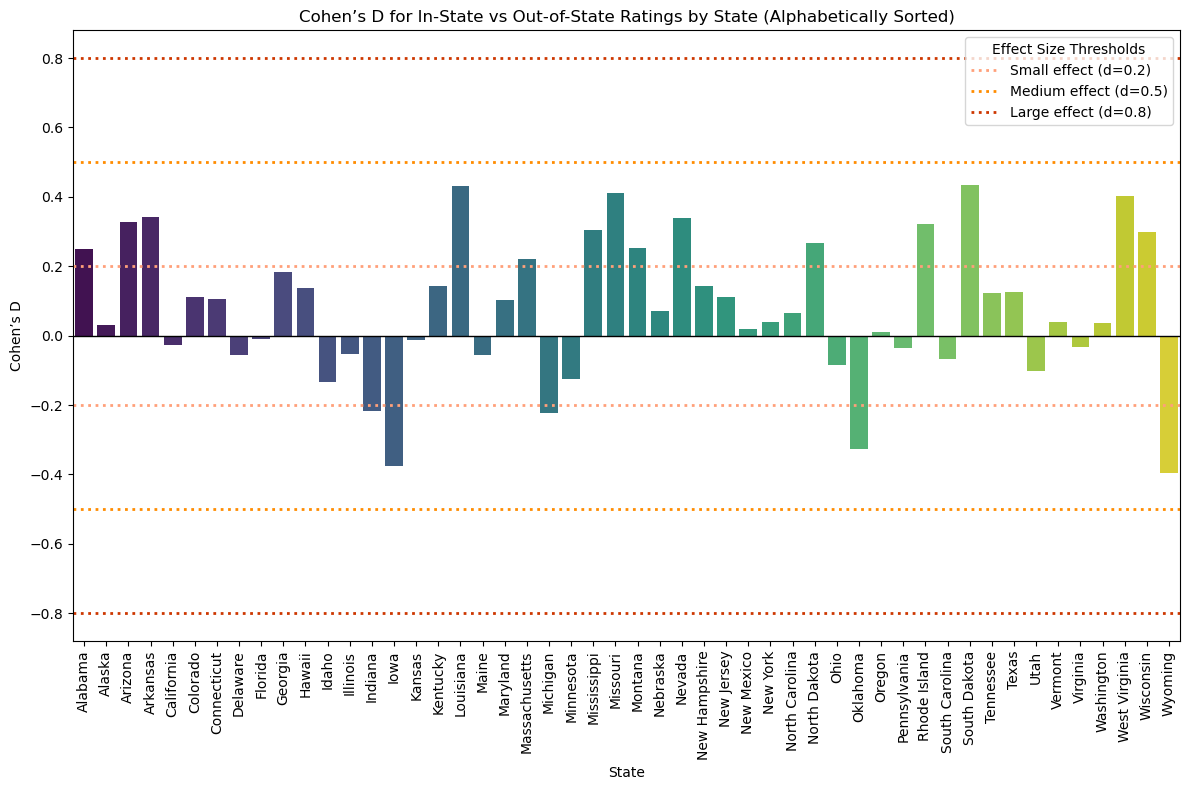

In [28]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1) 
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['beer_state'].unique()
unique_states.sort()

cohen_results = {}

for state in unique_states:
    subset = US_ratings[US_ratings['beer_state'] == state]
    in_state_ratings = subset[subset['state_IN_VS_OUT'] == 'In-State']['rating']
    out_of_state_ratings = subset[subset['state_IN_VS_OUT'] == 'Out-of-State']['rating']
    
    if len(in_state_ratings) == 0 or len(out_of_state_ratings) == 0:
        cohen_results[state] = np.nan
        continue
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    cohen_results[state] = d_value

cohen_df = pd.DataFrame.from_dict(cohen_results, orient='index', columns=['Cohen_d'])
cohen_df.sort_values(by='Cohen_d', inplace=True)  # Sort by Cohen's D value

cohen_df_no_nan = cohen_df.dropna()

# Plot 1: States sorted by Cohen's D value
plt.figure(figsize=(12, 8))
sns.barplot(
    x=cohen_df_no_nan.index, 
    y='Cohen_d', 
    data=cohen_df_no_nan, 
    palette='viridis'
)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State (Sorted by Cohen’s D)')
plt.xticks(rotation=90)
plt.legend(title='Effect Size Thresholds', loc='upper right')
plt.tight_layout()
plt.show()

# Plot 2: States sorted alphabetically
cohen_alphabetical = cohen_df_no_nan.copy()
cohen_alphabetical.sort_index(inplace=True)  # Sort by state name (index)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=cohen_alphabetical.index, 
    y='Cohen_d', 
    data=cohen_alphabetical, 
    palette='viridis'
)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='#FFA07A', linestyle=':', linewidth=2, label='Small effect (d=0.2)')
plt.axhline(y=-0.2, color='#FFA07A', linestyle=':', linewidth=2)
plt.axhline(y=0.5, color='#FF8C00', linestyle=':', linewidth=2, label='Medium effect (d=0.5)')
plt.axhline(y=-0.5, color='#FF8C00', linestyle=':', linewidth=2)
plt.axhline(y=0.8, color='#CD3700', linestyle=':', linewidth=2, label='Large effect (d=0.8)')
plt.axhline(y=-0.8, color='#CD3700', linestyle=':', linewidth=2)
plt.xlabel('State')
plt.ylabel('Cohen’s D')
plt.title('Cohen’s D for In-State vs Out-of-State Ratings by State (Alphabetically Sorted)')
plt.xticks(rotation=90)
plt.legend(title='Effect Size Thresholds', loc='upper right')
plt.tight_layout()
plt.show()


for this ^ the - means that they prefer out-of-state beers and + means they prefer in-state beers

-> over 0.2 or under -0.2 and plot the difference in average 
-> you are currently looking at alabama, comparing the alabamans rating alabama beer vs non-alabamans rating alabama beer

-> next thing: alamabams rating instate beers vs rating out of state beers 

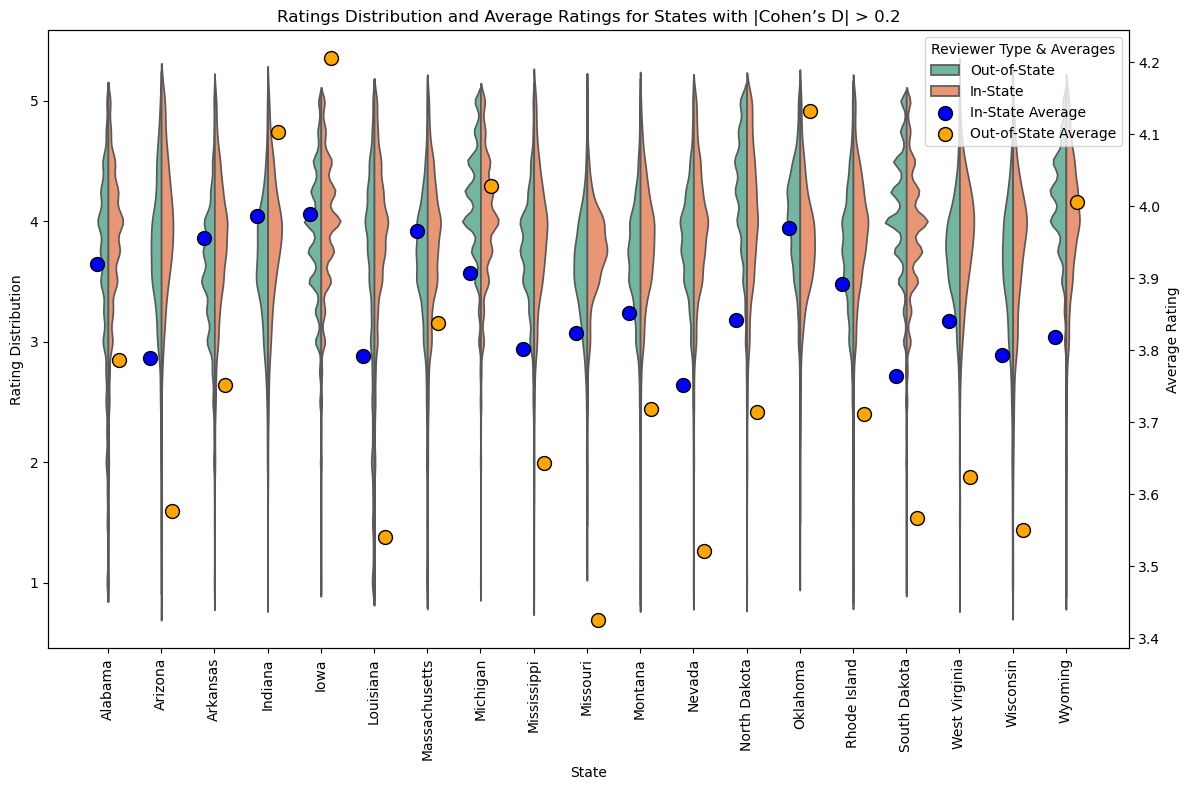

In [22]:
significant_states = cohen_df_no_nan[
    (cohen_df_no_nan['Cohen_d'] > 0.2) | (cohen_df_no_nan['Cohen_d'] < -0.2)
].index
significant_states = sorted(significant_states)

filtered_ratings = US_ratings[US_ratings['beer_state'].isin(significant_states)]

average_ratings = filtered_ratings.groupby(['beer_state', 'state_IN_VS_OUT'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 8))

ax1 = sns.violinplot(
    x='beer_state', 
    y='rating', 
    hue='state_IN_VS_OUT', 
    data=filtered_ratings, 
    split=True, 
    inner=None, 
    palette='Set2'
)

ax1.legend_.remove()

ax1.set_xlabel('State')
ax1.set_ylabel('Rating Distribution')
ax1.set_title('Ratings Distribution and Average Ratings for States with |Cohen’s D| > 0.2')

ax2 = ax1.twinx()

colors = {'In-State': 'blue', 'Out-of-State': 'orange'}

labels_added = set()  

for i, state in enumerate(significant_states):
    state_avg_ratings = average_ratings[average_ratings['beer_state'] == state]
    
    for relation, color in colors.items():
        avg_value = state_avg_ratings[state_avg_ratings['state_IN_VS_OUT'] == relation]['rating']
        if not avg_value.empty:
            x_pos = i  # Position at the state's index
            offset = -0.2 if relation == 'In-State' else 0.2
            label = f'{relation} Average' if f'{relation} Average' not in labels_added else None
            
            ax2.scatter(x_pos + offset, avg_value, 
                        color=color, 
                        edgecolor='black', 
                        s=100, 
                        zorder=3, 
                        label=label)
            if label is not None:
                labels_added.add(label)

ax2.set_ylabel('Average Rating')

ax1.set_xticks(range(len(significant_states)))  
ax1.set_xticklabels(significant_states, rotation=90)  

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines_combined, labels_combined = [], []
for l, la in zip(lines_1 + lines_2, labels_1 + labels_2):
    if la not in labels_combined:
        lines_combined.append(l)
        labels_combined.append(la)

ax1.legend(lines_combined, labels_combined, title='Reviewer Type & Averages', loc='upper right')

plt.tight_layout()
plt.show()


             state  average_in_state  average_out_of_state  difference  \
0        Wisconsin          3.793467              3.968340   -0.174872   
1           Hawaii          3.717298              3.881467   -0.164169   
2          Arizona          3.789245              3.943775   -0.154530   
3            Idaho          3.668379              3.805853   -0.137473   
4         Nebraska          3.774471              3.901185   -0.126714   
5           Nevada          3.751859              3.865740   -0.113881   
6        Louisiana          3.791667              3.894495   -0.102828   
7    New Hampshire          3.864387              3.966594   -0.102207   
8         Missouri          3.823841              3.912568   -0.088727   
9       Washington          3.811794              3.884601   -0.072807   
10            Utah          3.801265              3.873391   -0.072126   
11        Maryland          3.823831              3.895648   -0.071817   
12           Texas          3.822027  

/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/3405762031.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')


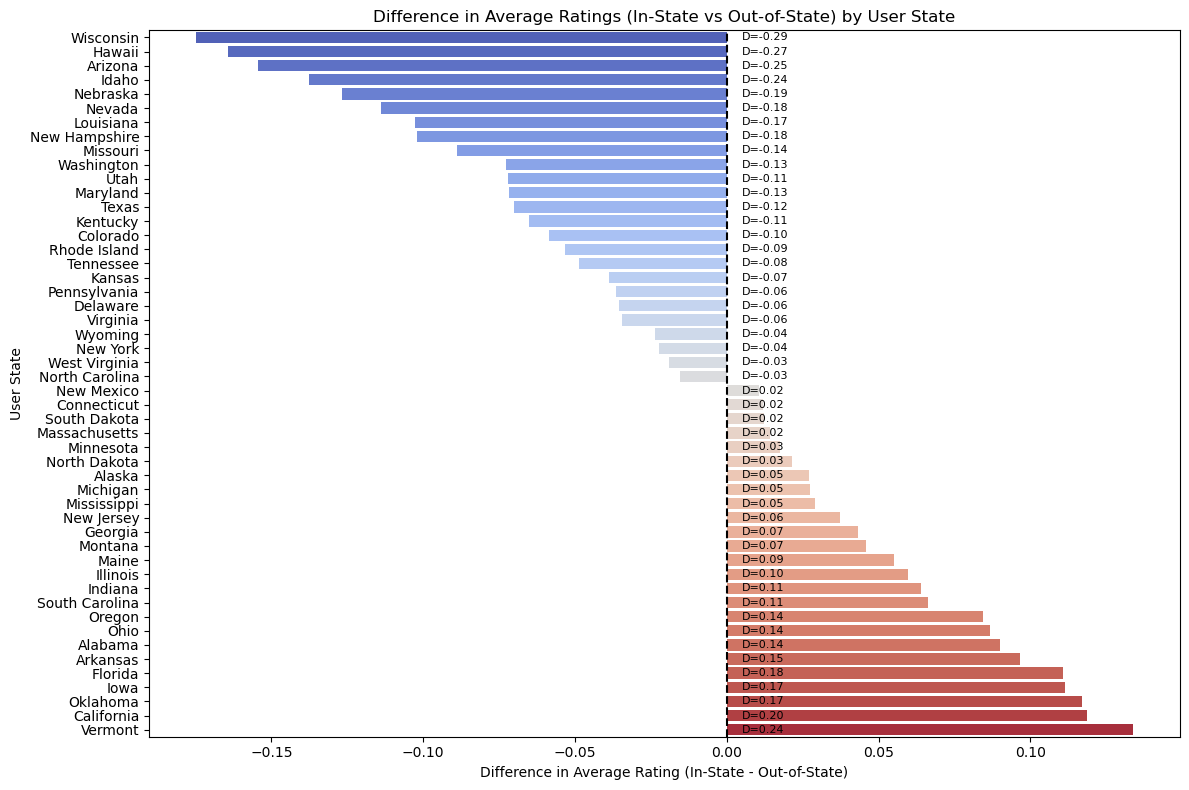

        state  average_in_state  average_out_of_state  difference   cohen_d
0   Wisconsin          3.793467              3.968340   -0.174872 -0.290529
1      Hawaii          3.717298              3.881467   -0.164169 -0.270881
2     Arizona          3.789245              3.943775   -0.154530 -0.252784
3       Idaho          3.668379              3.805853   -0.137473 -0.236599
4  California          4.013132              3.894640    0.118492  0.202219
5     Vermont          4.089329              3.955513    0.133816  0.239949


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/3405762031.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')


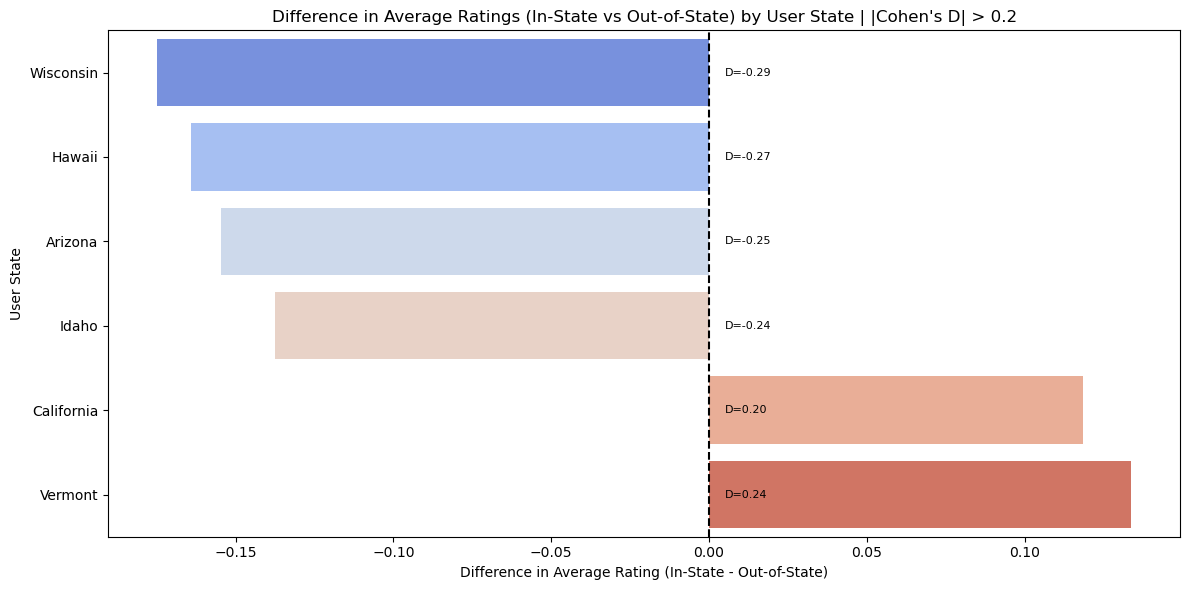

In [23]:
def cohen_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x, ddof=1), np.std(y, ddof=1)  # Using sample standard deviation
    pooled_std = np.sqrt(((nx - 1) * std_x ** 2 + (ny - 1) * std_y ** 2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (mean_x - mean_y) / pooled_std

unique_states = US_ratings['user_state'].unique()

results = []

for state in unique_states:
    state_users = US_ratings[US_ratings['user_state'] == state].copy()
    
    if state_users.empty:
        continue
    
    state_users['beer_origin'] = np.where(
        state_users['beer_state'] == state, 
        'In-State Beer', 
        'Out-of-State Beer'
    )
    
    in_state_ratings = state_users[state_users['beer_origin'] == 'In-State Beer']['rating']
    out_of_state_ratings = state_users[state_users['beer_origin'] == 'Out-of-State Beer']['rating']
    
    if in_state_ratings.empty or out_of_state_ratings.empty:
        continue
    
    average_in_state = in_state_ratings.mean()
    average_out_of_state = out_of_state_ratings.mean()
    
    d_value = cohen_d(in_state_ratings, out_of_state_ratings)
    
    rating_diff = average_in_state - average_out_of_state
    
    results.append({
        'state': state,
        'average_in_state': average_in_state,
        'average_out_of_state': average_out_of_state,
        'difference': rating_diff,
        'cohen_d': d_value
    })

state_results = pd.DataFrame(results)
state_results.sort_values(by='difference', inplace=True)  # Sort by difference
state_results.reset_index(drop=True, inplace=True)

print(state_results)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=state_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State")
plt.ylabel("User State")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.axvline(0, color='black', linestyle='--')

for i, row in state_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax.text(text_x, i, d_val, 
            color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

filtered_results = state_results[abs(state_results['cohen_d']) > 0.2].copy()
filtered_results.sort_values(by='difference', inplace=True)
filtered_results.reset_index(drop=True, inplace=True)

print(filtered_results)

plt.figure(figsize=(12, 6))
ax2 = sns.barplot(data=filtered_results, y='state', x='difference', palette='coolwarm', orient='h')
plt.title("Difference in Average Ratings (In-State vs Out-of-State) by User State | |Cohen's D| > 0.2")
plt.xlabel("Difference in Average Rating (In-State - Out-of-State)")
plt.ylabel("User State")
plt.axvline(0, color='black', linestyle='--')

for i, row in filtered_results.iterrows():
    d_val = f"D={row['cohen_d']:.2f}" if not pd.isna(row['cohen_d']) else "D=NaN"
    text_x = 0.005  
    ax2.text(text_x, i, d_val, 
             color='black', ha='left', va='center', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()


/var/folders/qf/dk7tzwpd1_j2430sljmhw_c40000gq/T/ipykernel_81751/84726757.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]],


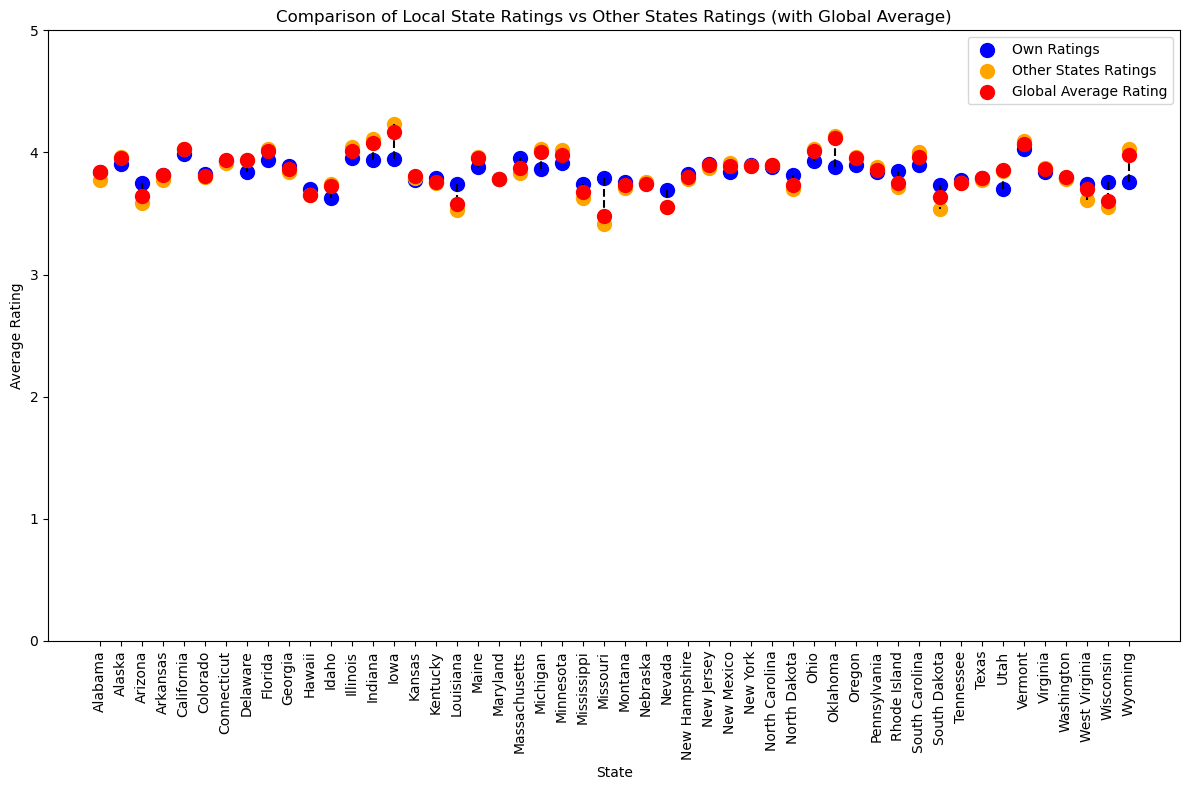

In [24]:
#global average rating for each state’s beer
global_avg_ratings = US_ratings.groupby('beer_state')['rating'].mean()

plt.figure(figsize=(12, 8))

plt.scatter(ratings_comparison.index, ratings_comparison['own_beer_avg'], label='Own Ratings', color='blue', s=100, zorder=2)
plt.scatter(ratings_comparison.index, ratings_comparison['other_states_avg'], label='Other States Ratings', color='orange', s=100, zorder=2)

plt.scatter(global_avg_ratings.index, global_avg_ratings, label='Global Average Rating', color='red', s=100, zorder=3)

#lines connecting the dots for visibility
for i in range(len(ratings_comparison)):
    plt.plot([ratings_comparison.index[i], ratings_comparison.index[i]], 
             [ratings_comparison['own_beer_avg'][i], ratings_comparison['other_states_avg'][i]], 
             color='black', linestyle='--')

plt.xlabel('State')
plt.ylabel('Average Rating')
plt.title('Comparison of Local State Ratings vs Other States Ratings (with Global Average)')
plt.xticks(rotation=90)
plt.ylim(0,5)
plt.legend()
plt.tight_layout()

plt.show()


Added global average of the state beers added
We need to perform statistical tests in order to verify if there is a statistical difference in the way people from a state rank their own beers compared to how other states rank said state. We could take each state independently

Questions we need to answer:

Do Texans[replace state with any state] rate their own beer higher than other US states rate Texan beer?
Do Texans[replace state with any state] rate their own beer higher than the global rating of Texan beer?


WHAT TYPE OF TEST DE WE DO to quantify the difference in average rating?
Things to consider when selecting the stat test: normality? Independence of groups? High volume of data? Large difference in number of data points for local ratings vs all other ratings?

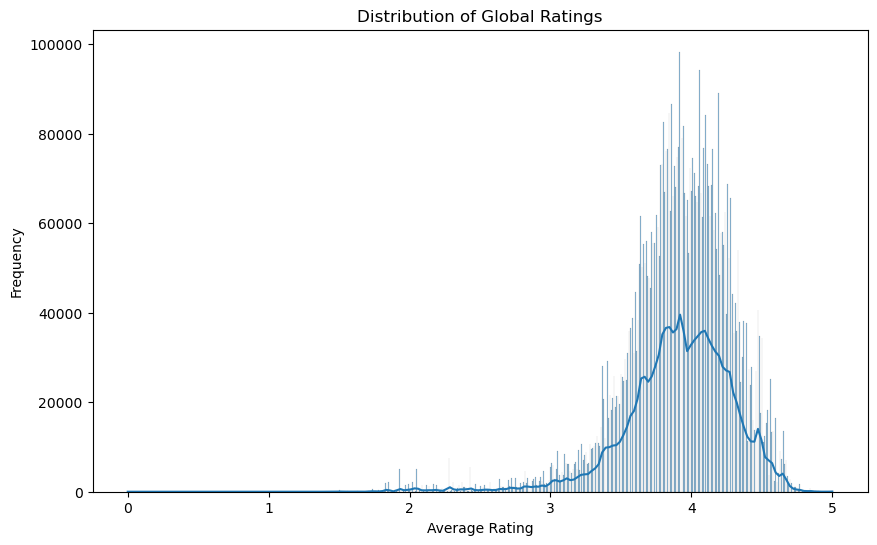

In [25]:
#Point of this is to check if the data is normally distributed

#histogram of the average ratings
plt.figure(figsize=(10, 6))
sns.histplot(US_ratings['avg'], kde=True)
plt.title("Distribution of Global Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

In [26]:
#Test allows us to statistically verify if the data is normally distributed
ks_test = stats.kstest(US_ratings['avg'], 'norm', args=(US_ratings['avg'].mean(), US_ratings['avg'].std()))
print("Kolmogorov-Smirnov Test:")
print(f"Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")


Kolmogorov-Smirnov Test:
Statistic=0.06600630121805295, p-value=0.0


OK we can definitively say that this data is not normally distributed!!! p value = 0.0 :(
Below I have proposed a Mann-Whitney U test but I this would work better with small datasets

             state  state_avg  other_states_avg        p_value  \
4         Missouri   3.823841          3.425019   0.000000e+00   
31       Louisiana   3.791667          3.540684  5.045716e-189   
1        Wisconsin   3.793467          3.550564   0.000000e+00   
29          Nevada   3.751859          3.520708   4.242437e-24   
36   West Virginia   3.841070          3.623372   2.775359e-25   
8          Arizona   3.789245          3.577505   9.146263e-96   
42        Arkansas   3.955613          3.752037   3.571575e-22   
32    South Dakota   3.764837          3.566424   4.742261e-20   
40    Rhode Island   3.891898          3.710939   8.776180e-74   
35     Mississippi   3.801965          3.643772   1.455969e-23   
47         Montana   3.852338          3.718161   1.327150e-28   
44         Alabama   3.919936          3.786342   8.926670e-42   
21   Massachusetts   3.966313          3.837522   0.000000e+00   
46    North Dakota   3.841897          3.714255   3.409497e-05   
13        

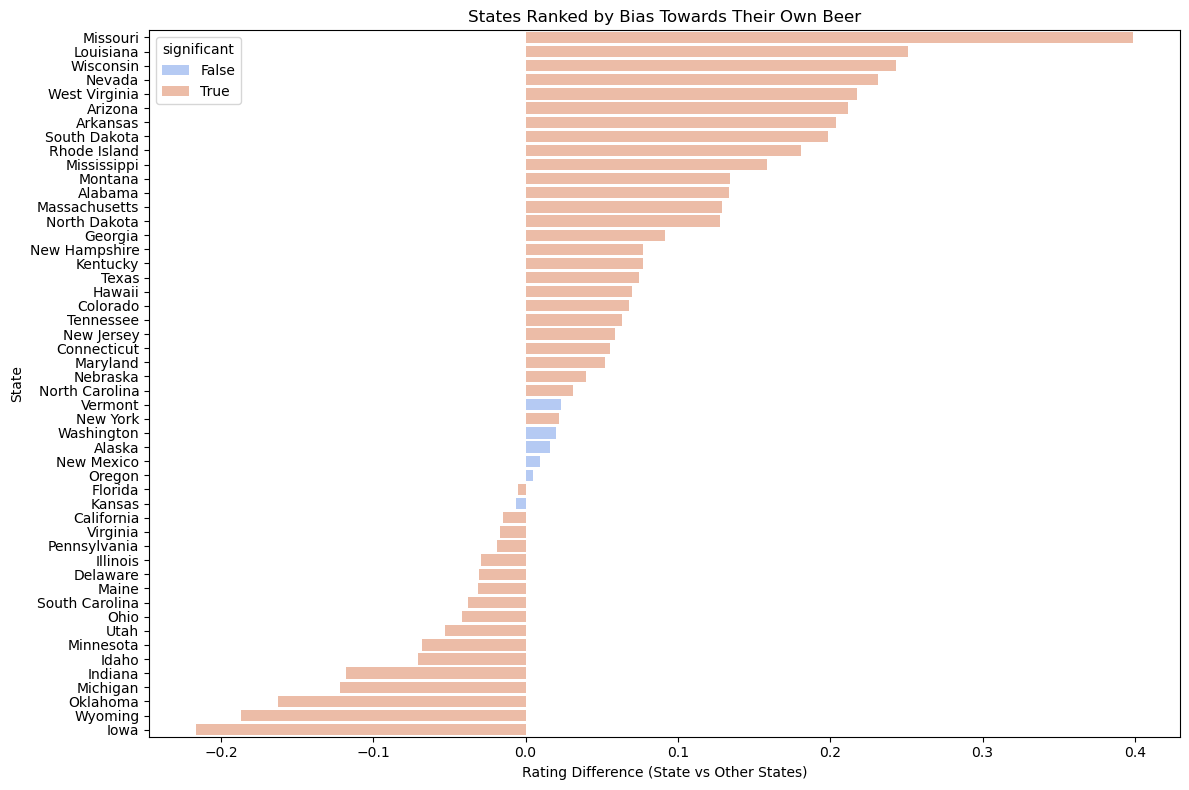

In [27]:
#calculate Mann-Whitney U and average ratings for each state
def calculate_bias(state, US_ratings):

    state_ratings = US_ratings[(US_ratings['user_state'] == state) & (US_ratings['beer_state'] == state)]['rating']
    other_states_ratings = US_ratings[(US_ratings['user_state'] != state) & (US_ratings['beer_state'] == state)]['rating']
    
    state_avg = state_ratings.mean()
    other_states_avg = other_states_ratings.mean()
    
    stat, p_value = mannwhitneyu(state_ratings, other_states_ratings, alternative='two-sided')
    
    return state_avg, other_states_avg, p_value


states = US_ratings['user_state'].unique()

bias_results = []

for state in states:
    state_avg, other_states_avg, p_value = calculate_bias(state, US_ratings)
    bias_results.append({
        'state': state,
        'state_avg': state_avg,
        'other_states_avg': other_states_avg,
        'p_value': p_value,
        'rating_difference': state_avg - other_states_avg
    })


bias_df = pd.DataFrame(bias_results)

bias_df['significant'] = bias_df['p_value'] < 0.05


bias_df = bias_df.sort_values(by=['rating_difference', 'significant'], ascending=False)
print(bias_df)

plt.figure(figsize=(12, 8))
sns.barplot(x='rating_difference', y='state', data=bias_df, palette='coolwarm', hue='significant')

plt.xlabel('Rating Difference (State vs Other States)')
plt.ylabel('State')
plt.title('States Ranked by Bias Towards Their Own Beer')
plt.tight_layout()

plt.show()

In the graph the the negative scores is where the state is ranking their beer HIGHER than the US average